<a href="https://colab.research.google.com/github/Brimarolafs/Gervigreind-Lokaverkefni-BJV/blob/main/Gervi_loka.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from PIL import Image
import numpy as np

def load_image(infilename, grayscale = False):
    if grayscale:
        img = Image.open( infilename ).convert('L')
    else:
        img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data

def save_image( npdata, outfilename ) :
    img = Image.fromarray( np.asarray( np.clip(npdata,0,255), dtype="uint8"), "L" )
    img.save( outfilename )

def compress(infilename, size = 64, grayscale = False):
    if grayscale:
        img = Image.open(infilename).convert('L')
    else:
        img = Image.open(infilename)
    img = img.resize((size,size))
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data

def compression_pipeline(path_to_files, size = 64, grayscale = False):
    import os
    images = []
    for i,filename in enumerate(os.listdir(path_to_files)):
        img = compress(path_to_files + '/'+filename, size, grayscale)
        images.append(img)
    return np.array(images)

def pipeline(path_to_files, grayscale = False):
    import os
    images = []
    for i,filename in enumerate(os.listdir(path_to_files)):
        img = load_image(path_to_files + '/'+filename, grayscale)
        images.append(img)
    return np.array(images)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
folder_path = '/content/drive/MyDrive/pokemon_jpg/pokemon_jpg'

data = pipeline(folder_path, grayscale = False)/255

In [ ]:
compressed_data = compression_pipeline(folder_path, grayscale=False)/255

In [ ]:
data.shape

(819, 256, 256, 3)

In [ ]:
compressed_data.shape

(819, 64, 64, 3)

In [ ]:
import sklearn.model_selection
import numpy as np
from sklearn import preprocessing

x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(compressed_data, data, test_size = 0.2, random_state = 42)

print('X_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

X_train shape: (655, 64, 64, 3)
655 train samples
164 test samples


In [ ]:
#Model 1
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential
from keras.utils import np_utils
from keras import optimizers
from keras import layers
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D,Activation
from keras import regularizers
from tensorflow.keras.models import Model

In [ ]:
def scheduler(n,lr):
    if n <= 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

def train_and_get_imgs(autoenc_class):
    autoencoder = autoenc_class()
    autoencoder.build((None,64,64,3))
    opt = keras.optimizers.Adam(learning_rate=0.001)
    l1 = keras.losses.SparseCategoricalCrossentropy()
    l2 = keras.losses.MeanSquaredError()
    autoencoder.summary()
    autoencoder.compile(optimizer=opt, loss=l2)
    autoencoder.fit(x_train, y_train,
                epochs=30,
                batch_size=32,
                shuffle=True,
                callbacks = [keras.callbacks.LearningRateScheduler(scheduler)],
                validation_data = (x_test,y_test)
                )
    encoded_imgs = autoencoder.encoder(x_test).numpy()
    decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
    return encoded_imgs,decoded_imgs

In [ ]:
import matplotlib.pyplot as plt

def print_results(encoded_imgs,decoded_imgs):
    n = 8
    plt.figure(figsize=(1,n), dpi = 1000)
    for i in range(n):
        # display original
        ax = plt.subplot(n, 3, 3*i +1)
        plt.imshow(x_test[i])
        plt.title("in")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # k = int(np.sqrt(encoded_imgs.shape[1]))
        # ax = plt.subplot(3, n, i + 1 + n)
        # plt.imshow(encoded_imgs[i].reshape((k,k)))
        # plt.title("encoded")
        # plt.gray()
        # ax.get_xaxis().set_visible(False)
        # ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(n, 3, 3*i + 2)
        plt.imshow(decoded_imgs[i])
        plt.title("out")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(n, 3, 3*i + 3)
        plt.imshow(y_test[i])
        plt.title("org")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.subplots_adjust(hspace = 1.1)  
    plt.show()

In [ ]:
def pipe(autoenc_class):
    a,b = train_and_get_imgs(autoenc_class)
    print_results(a,b)

In [ ]:
class Autoencoder_simple_mlp(Model):
  def __init__(self):
    latent_dim = 3*32*32
    super(Autoencoder_simple_mlp, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
        layers.Flatten(),
        # layers.Dense(latent_dim, activation='relu')
        ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(3*256 * 256, activation='sigmoid'),
      layers.Reshape((256,256,3))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [ ]:
pipe(Autoencoder_simple_mlp)

ResourceExhaustedError: ignored

Model: "autoencoder_2_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_22 (Sequential)  (None, 64, 64, 200)       259740    
                                                                 
 sequential_23 (Sequential)  (None, 256, 256, 3)       532801    
                                                                 
Total params: 792,541
Trainable params: 792,541
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
21/21 [==============================] - 13s 568ms/step - loss: 3.1701 - val_loss: 0.0793 - lr: 0.0010
Epoch 2/30
21/21 [==============================] - 12s 559ms/step - loss: 0.0590 - val_loss: 0.0435 - lr: 0.0010
Epoch 3/30
21/21 [==============================] - 12s 556ms/step - loss: 0.0376 - val_loss: 0.0302 - lr: 0.0010
Epoch 4/30
21/21 [==============================] - 12s 551ms/step - loss: 0.0281 - val_loss: 0.02

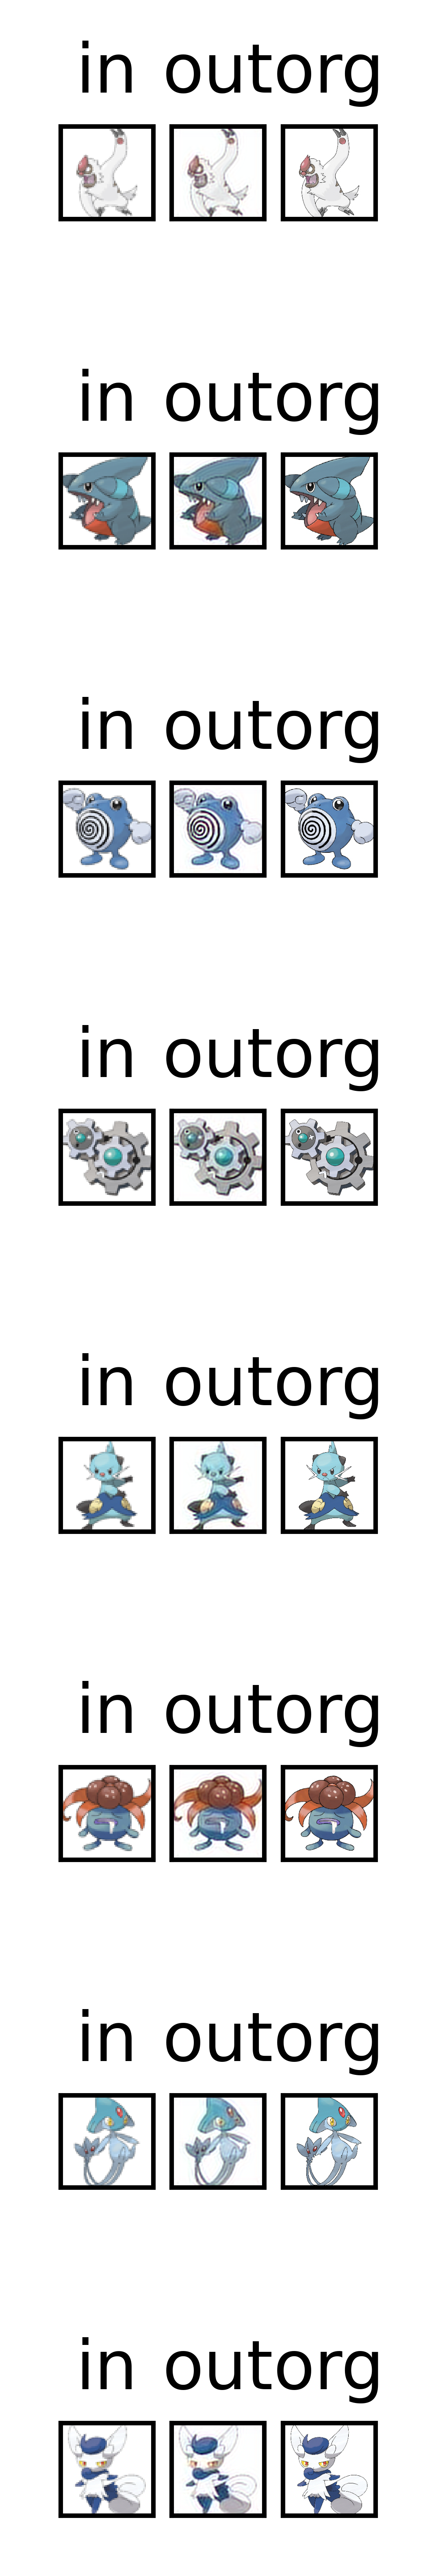

In [ ]:
class Autoencoder_2(Model):
  def __init__(self)
    super(Autoencoder_2, self).__init__()
    self.encoder = tf.keras.Sequential([
        layers.Conv2D(filters = 30, kernel_size = (7,7),padding = 'same', data_format = 'channels_last',activation = 'relu'),
        layers.Conv2D(filters = 100, kernel_size = (5,5),padding = 'same', data_format = 'channels_last',activation = 'relu'),
        layers.Conv2D(filters = 200, kernel_size = (3,3), padding = 'same', data_format = 'channels_last',activation = 'relu')
        ])
    self.decoder = tf.keras.Sequential([
        layers.UpSampling2D(),
        layers.Conv2D(filters = 50, padding = 'same', kernel_size = 7),
        layers.UpSampling2D(),
        layers.Conv2D(filters = 30, padding = 'same', kernel_size = 5),
        layers.Conv2D(filters = 15, padding = 'same', kernel_size = 3),
        layers.Conv2D(filters = 7, padding = 'same', kernel_size = 3),
        layers.Conv2D(filters = 3, padding = 'same', kernel_size = 3),
        layers.Conv2D(filters = 3, padding = 'same', kernel_size = 1)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
pipe(Autoencoder_2)

Allt sem er hér fyrir neðan er bara test ekki neitt sem virkar.

In [ ]:
#make autoencoder
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential
from keras.utils import np_utils
from keras import optimizers
from keras import layers
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D,Activation

#input is 819 transparent Pokemon images in png format size 256x256.
#output is 819 transparent Pokemon images in png format size 256x256.

#add encoded and decoded


lr = 2e-4
batch_size = 16
input_shape = keras.Input(shape=(256, 256, 3))

x = layers.Conv2D(64, 3, activation="relu", padding="same")(input_shape)
x = layers.MaxPooling2D(2, padding="same")(x)
x = layers.Conv2D(32, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(2, padding="same")(x)
x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(2, padding="same")(x)
x = layers.Conv2D(8, 3, activation="relu", padding="same")(x)
encoded = layers.MaxPooling2D(2, padding="same")(x)

# at this point the representation is (16, 16, 8) i.e. 2048-dimensional

x = layers.Conv2D(8, 3, activation="relu", padding="same")(encoded)
x = layers.UpSampling2D(2)(x)
x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
x = layers.UpSampling2D(2)(x)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.UpSampling2D(2)(x)
x = layers.Conv2D(64, 3, activation="relu")(x)
x = layers.UpSampling2D(2)(x)
decoded = layers.Conv2D(4, 3, activation="sigmoid", padding="same")(x)

autoencoder = keras.Model(input_shape, decoded)

autoencoder.compile(optimizer='adam', loss='l2')



autoencoder.summary()

In [ ]:
np.shape(data)
data = data.reshape((len(data), np.prod(data.shape[1:])))

In [ ]:
import matplotlib.pyplot as plt

num_epochs = 10

history = autoencoder.fit(data, data
                    , batch_size = batch_size
                    , epochs = num_epochs
                    , verbose = 1
)


bla = autoencoder.predict(data[0])

plt.imshow(bla)


In [ ]:
import visualkeras

visualkeras.layered_view(autoencoder).show() # display using your system viewer
visualkeras.layered_view(autoencoder, to_file='autoencoder.png') # write to disk

In [ ]:
!pip install visualkeras

In [ ]:

input_shape = keras.Input(shape=(256, 256, 4))

encoded = layers.Dense(2048, activation='relu')(input_shape)
encoded = layers.Dense(1024, activation='relu')(encoded)
encoded = layers.Dense(512, activation='relu')(encoded)
encoded = layers.Dense(256, activation='relu')(encoded)
encoded = layers.Dense(128, activation='relu')(encoded)
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(32, activation='relu')(encoded)

decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(256, activation='relu')(decoded)
decoded = layers.Dense(512, activation='relu')(decoded)
decoded = layers.Dense(1024, activation='relu')(decoded)
decoded = layers.Dense(2048, activation='relu')(decoded)

autoencoder = keras.Model(input_shape, decoded)

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.summary()